
# Uma breve introdução ao Machine Learning: Dia 5

Gabriel Wendell Celestino Rocha

Material de um minicurso de introdução ao Machine Learning oferecido pelo [PET - Física](https://petfisica.home.blog).

O conteúdo é mantido no [GitHub](https://github.com/GabrielWendell/Intro_ML) e distribuídos sob uma [licença BSD3](https://opensource.org/licenses/BSD-3-Clause).

- [Veja a tabela de conteúdos](https://github.com/GabrielWendell/Intro_ML/blob/main/Infomações/Conteúdos.ipynb)

Este `Notebook` pode, opcionalmente, ser visto como uma [apresentação de slides](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f). Para apresentar os slides localmente, use:

```Python
$ jupyter nbconvert Dia5.ipynb --to slides --post serve
```

---

### Bibliotecas necessárias

In [1]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

%matplotlib notebook

def opt_plot():
    # plt.style.use('dark_background')
    plt.grid(True, linestyle=':', color='0.50')
    plt.minorticks_on()
    plt.tick_params(axis='both',which='minor', direction = "in",
                        top = True,right = True, length = 5,width = 1,labelsize = 15)
    plt.tick_params(axis='both',which='major', direction = "in",
                        top = True,right = True, length = 8,width = 1,labelsize = 15)

### Versões das bibliotecas

In [2]:
%load_ext version_information
%version_information Matplotlib, Numpy, Pandas, Seaborn

Software versions
Python 3.9.8 64bit [MSC v.1929 64 bit (AMD64)]
IPython 8.0.1
OS Windows 10 10.0.19043
Matplotlib 3.5.1
Numpy 1.22.2
Pandas 1.4.0
Seaborn 0.11.2
Sat Jul 09 10:29:29 2022 Hora Padrão de Buenos Aires

#### Instalação:

```
$ pip install version_information
```

---

Carregamos apenas os módulos `scikit-learn` que precisamos:

In [3]:
from sklearn import cluster, decomposition, metrics, manifold

# Baixando os dados

In [4]:
circles_data = pd.read_hdf('Data/circles_data.hf5')
circles_targets = pd.read_hdf('Data/circles_targets.hf5')

In [5]:
ess_data = pd.read_hdf('Data/ess_data.hf5')
ess_targets = pd.read_hdf('Data/ess_targets.hf5')

# Adaptando métodos lineares para resolver problemas não lineares

---

## 1. A Cura da Dimensionalidade

Já encontramos a "maldição da dimensionalidade" no contexto da redução da dimensionalidade, mas às vezes uma grande dimensionalidade pode ser uma cura. Como exemplo motivador, considere os dados 2D plotados abaixo, que claramente contêm dois clusters com formas altamente não lineares:

In [6]:
def plot_circles(labels, data=circles_data):
    X = data.values
    cmap = sns.color_palette('viridis', 2)
    c = [cmap[label] for label in labels]
    plt.figure(figsize = (8,5))
    plt.scatter(X[:, 0], X[:, 1], c=c)
    plt.gca().set_aspect(1)
    opt_plot()
    plt.show()

<IPython.core.display.Javascript object>


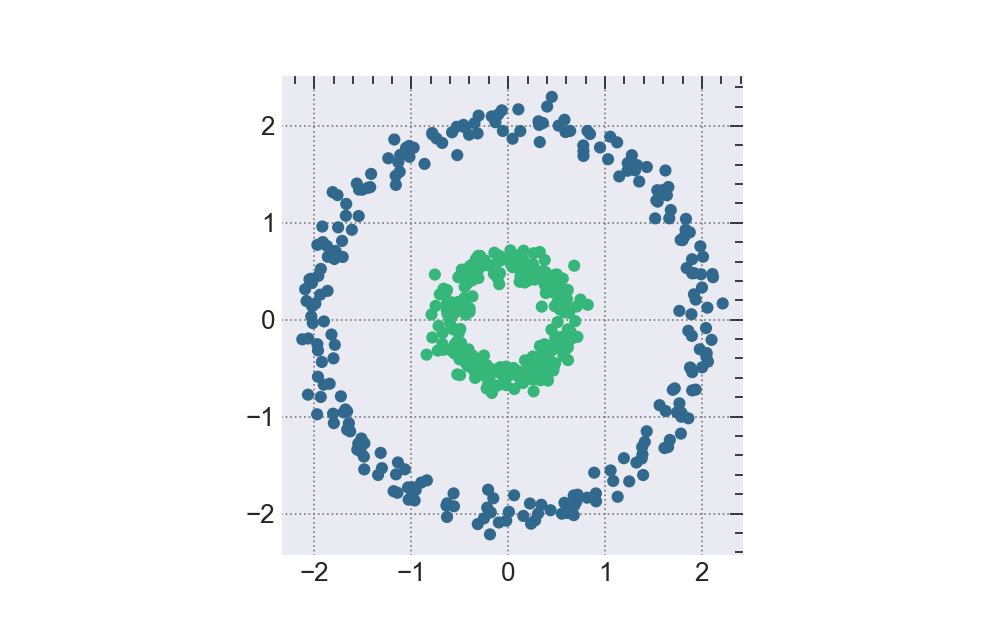

In [7]:
plot_circles(labels=circles_targets['y'])

O gráfico acima é colorido usando os rótulos verdadeiros armazenados na coluna `y` de `circles_targets`.

Vamos usar o KMeans para ajustar esses dados como dois *clusters* e plote os resultados usando `plot_circles(labels=fit.labels_)`. 

<IPython.core.display.Javascript object>


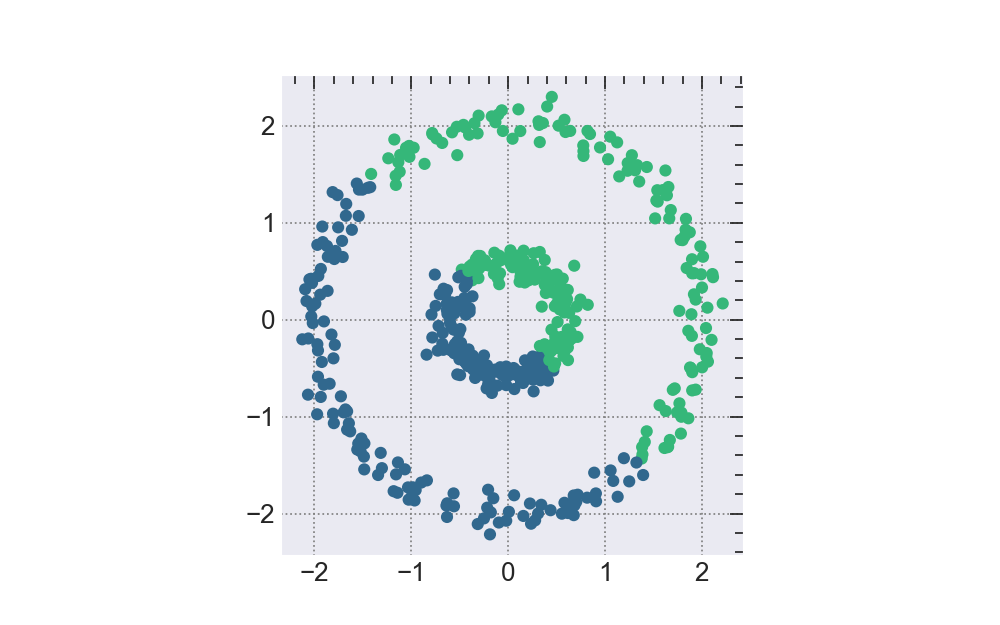

In [8]:
fit = cluster.KMeans(n_clusters=2).fit(circles_data)
plot_circles(labels = fit.labels_)

Os *clusters* encontrados pelo KMeans não são o que queremos, mas também não surpreende, dado que o KMeans particiona as amostras com uma linha divisória simples (ou hiperplano em dimensões superiores).

Vamos criar um novo conjunto de dados chamado `circles_3d` que é uma cópia de `circles_data`, mas com um novo recurso adicionado:

$$x_{2}=x_{0}^{2}+x_{1}^{2}.$$

Pense em como esse novo recurso altera o problema de *clustering*, se for o caso.

In [9]:
circles_3d = circles_data.copy()
circles_3d['x2'] = circles_3d['x0'] ** 2 + circles_3d['x1'] ** 2

Ao *aumentar* a dimensionalidade de nossos dados, transformamos um problema de agrupamento muito não linear em um problema linear trivial! Para ver isso, plote os dados em 3D:

<IPython.core.display.Javascript object>


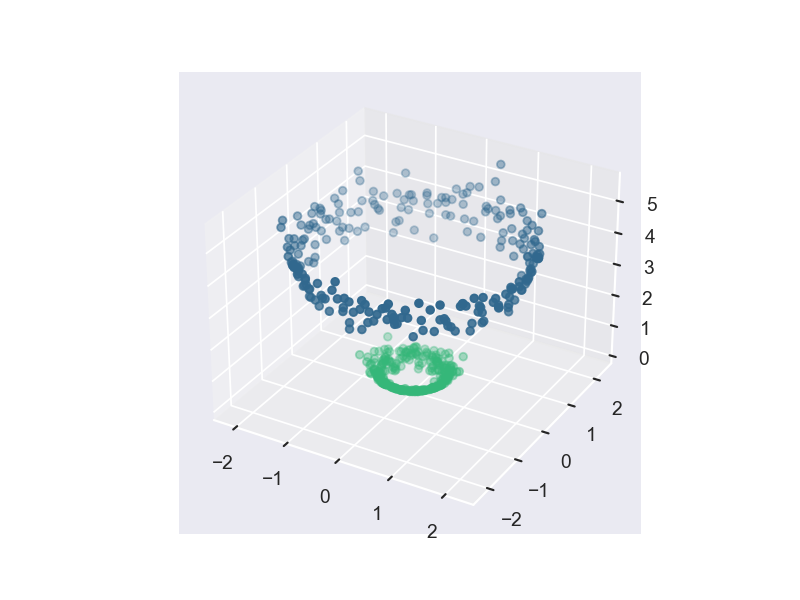

In [10]:
from mpl_toolkits.mplot3d import Axes3D

def plot_circles_3d(labels, data=circles_3d):
    X = data.values
    cmap = sns.color_palette('viridis', 2)
    c = [cmap[label] for label in labels]
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=c)
    
plot_circles_3d(labels=circles_targets['y'])

Finalmente, ajustamos para 2 *clusters* KMeans em nossos novos dados `circles_3d` e plotamos os resultados, como acima.

<IPython.core.display.Javascript object>


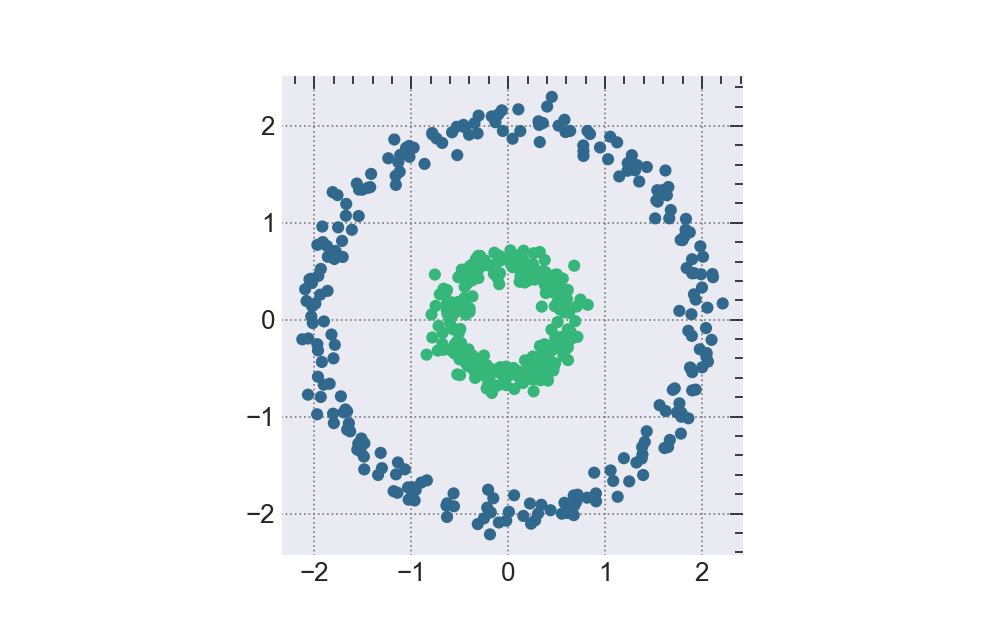

In [11]:
fit = cluster.KMeans(n_clusters=2).fit(circles_3d)
plot_circles(labels = fit.labels_)

Este é exatamente o resultado que queríamos, mas não tão surpreendente depois de ver o gráfico 3D acima.

## 2. Funções Kernel 

Existem muitas classes de problemas em que não linearidades em seus dados podem ser tratadas com métodos lineares, primeiro embutindo em uma dimensão mais alta.

A incorporação que usamos na seção anterior foi escolhida a dedo para esses dados, mas uma incorporação genérica geralmente funcionará se adicionar dimensões suficientes. Por exemplo, a função abaixo é comumente usada para incorporar recursos 2D $(x_{0},x_{1})$ em um espaço 7D:

$$\phi(x_0, x_1) = \begin{pmatrix}
x_0^2 \\
x_0 x_1 \\
x_1 x_0 \\
x_1^2 \\
\sqrt{2 c} x_0 \\
\sqrt{2 c} x_1 \\
c
\end{pmatrix}$$

In [12]:
def embed(data, c=1):
    # Incorpore X usando o kernel polinomial com n = 2, c = 1 (consulte a página 16 das notas do CS229 SVM)
    x0, x1 = data['x0'], data['x1']
    X = np.vstack([
        x0 * x0, x0 * x1, x1 * x0, x1 * x1,
        np.sqrt(2 * c) * x0, np.sqrt(2 * c) * x1,
        c + 0 * x0
    ]).T
    return pd.DataFrame(X, columns=('x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6'))

circles_embedded = embed(circles_data)

Um gráfico de pares dos `circles_data` incorporados em 7D mostra que essa é uma incorporação peculiar, mas permite uma separação linear dos dois clusters (por meio de seus componentes $x^{2}_{0}$ e $x^{2}_{1}$). Também parece ineficiente, com um recurso repetido $(x_{0}x_{1})$ e outro constante $(c)$. No entanto, este é apenas o membro mais simples de uma família de embeddings onde c desempenha um papel importante na fixação da normalização relativa dos diferentes grupos de [monômios](https://en.wikipedia.org/wiki/Monomial).

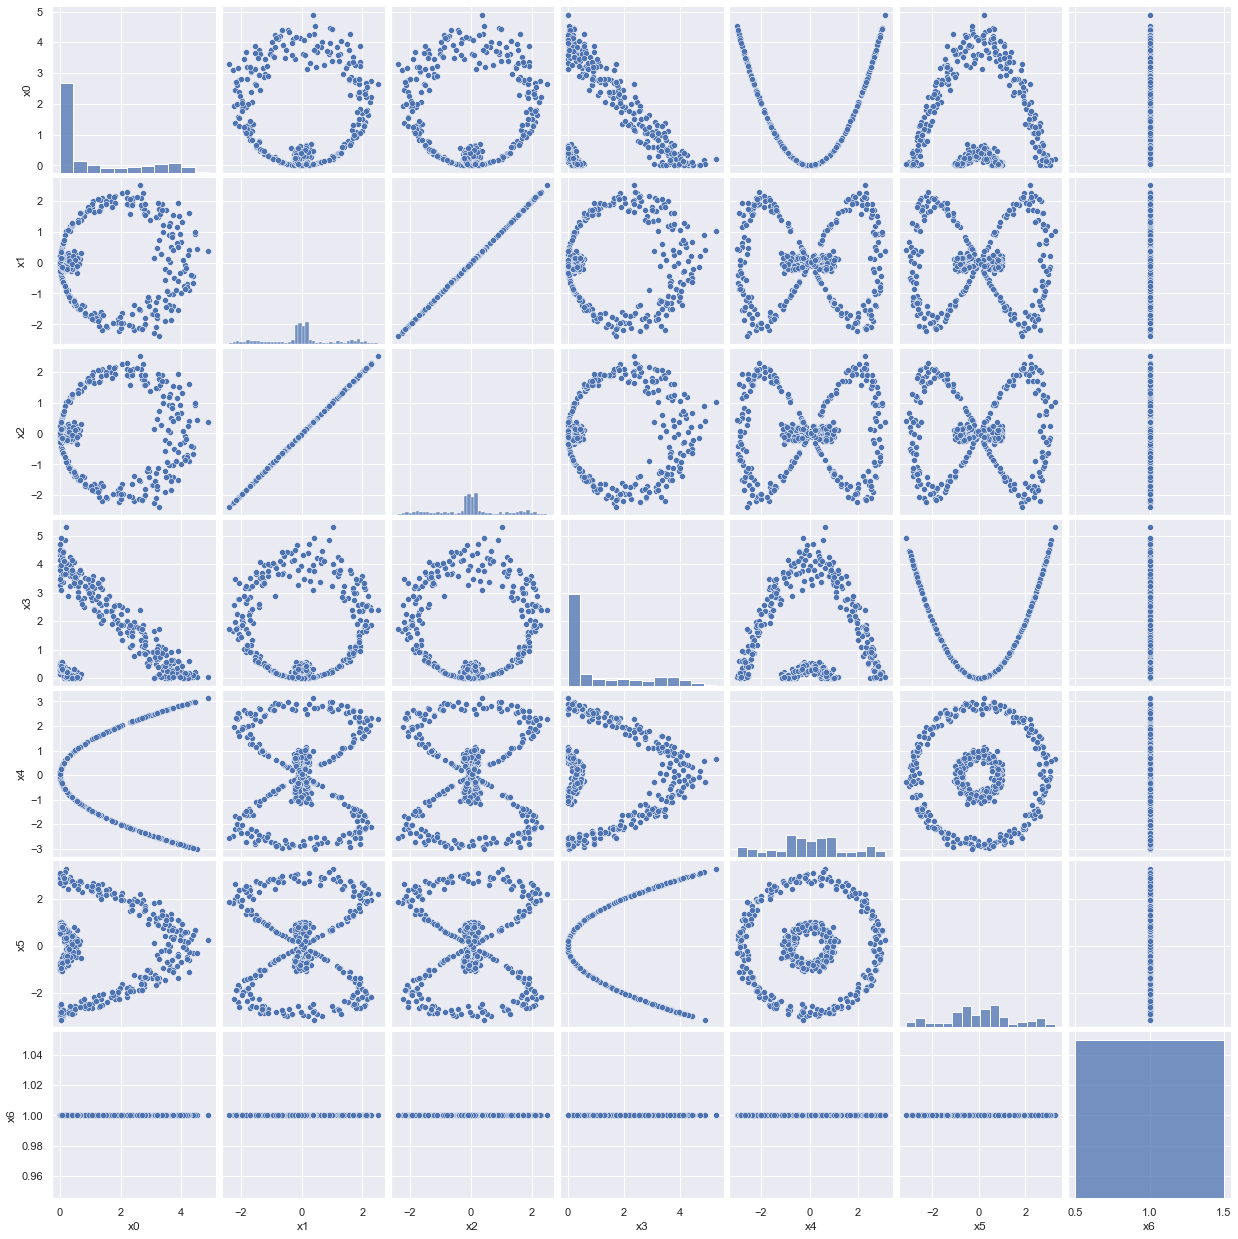

In [13]:
%matplotlib inline

sns.pairplot(circles_embedded, palette = 'crest')

A razão para escolher esta incorporação peculiar é que ela tem a seguinte propriedade muito útil:

$$\phi(X_{i})\cdot\phi(X_{j})=(X_{i}\cdot X_{j}+c)^{2},$$

onde $X_{i}$ e $X_{j}$ são amostras (*features*) arbitrárias (linhas) de nossos dados.

Primeiro, vamos verificar isso explicitamente para dados de círculos.

In [14]:
LHS = np.einsum('ik,jk->ij', circles_embedded, circles_embedded)
RHS = (np.einsum('ik,jk->ij', circles_data, circles_data) + 1) ** 2
assert np.allclose(LHS, RHS)

A razão pela qual essa propriedade é tão útil é que o RHS pode ser avaliado muito mais rápido do que o LHS e nunca exige que realmente incorporemos nossas amostras originais no espaço de dimensão superior.

As funções no espaço amostral que avaliam um produto escalar em um espaço diferente são chamadas de **funções kernel**:

$$K(X_{i},X_{j})=\phi(X_{i})\cdot\phi(X_{j}).$$

Uma função kernel é uma [medida de similaridade](https://en.wikipedia.org/wiki/Similarity_measure), pois mede a similaridade das amostras $i$ e $j$, com valor máximo para amostras idênticas e zero para amostras ortogonais. As medidas de similaridade estão relacionadas a medidas de distância (por exemplo, métricas na relatividade), mas com o comportamento oposto:

- amostras muito semelhantes: distância ~ 0, grande semelhança.
- amostras muito diferentes: grande distância, similaridade ~ 0.

A importância das funções do kernel é mais profunda do que apenas sua eficiência computacional: muitos algoritmos podem ser expressos usando apenas produtos de ponto entre amostras e, portanto, podem ser aplicados a dados incorporados em uma dimensão superior sem nunca fazer a incorporação. Esse insight é conhecido como o **truque do kernel**:

- Escolha uma função de kernel $K$.
- Escolha um algoritmo que possa ser expresso usando apenas produtos escalares.

Quando esses pré-requisitos são atendidos, o algoritmo pode ser aplicado de maneira fácil e eficiente a dados que são efetivamente impulsionados para um espaço de alta dimensão. Como vimos no exemplo acima, o principal benefício é que os dados não lineares agora podem ser analisados usando métodos lineares

Infelizmente, há um número limitado de funções de kernel adequadas $K$ (comece com o [teorema de Mercer](https://en.wikipedia.org/wiki/Mercer%27s_theorem) se você estiver interessado em aprender mais sobre o porquê disso). Já conhecemos o [kernel polinomial](https://en.wikipedia.org/wiki/Polynomial_kernel), que pode ser escrito de forma mais geral como:

$$K(X_{i},X_{j})=(\gamma X_{i}\cdot X_{j}+c)^{d},$$

onde $\gamma$, $c$ e $d$ são todos hiperparâmetros (nosso exemplo anterior usou $\gamma=1$, $c=1$ e $d=2$). O módulo `metric.pairwise` do `sklearn` pode calcular a matriz de todos os produtos escalares de amostra possíveis para este e outros kernels, por exemplo:

In [15]:
PK = metrics.pairwise.polynomial_kernel(circles_data, degree=2, gamma=1., coef0=1.)
assert np.allclose(LHS, PK)

Outros kernels populares são o [kernel sigmoid](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.sigmoid_kernel.html):

$$\boxed{K(X_{i},X_{j})=\tanh{(\gamma X_{i}\cdot X_{j}+c)}},$$

Além disso, o [kernel da função de base radial (rbf)](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html) (cujo embutimento é de dimensão infinita devido à expansão em série infinita de $e^{−x}$):

$$\boxed{K(X_{i},X_{j})=\exp{\Bigg(-\gamma|X_{i}-X_{j}|^{2}\Bigg)}}.$$

## 3. Kernel PCA

Como um exemplo do **truque do kernel**, o algoritmo PCA pode ser adaptado para usar apenas produtos de ponto para projetar cada amostra nos autovetores de dimensão superior. O [algoritmo KernelPCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) resultante é usado exatamente como os métodos de decomposição linear, mas com alguns hiperparâmetros adicionais, por exemplo.

```Python
fit = decomposition.KernelPCA(n_components=d, kernel='poly', gamma=1., degree=2).fit(X)
Y = fit.transform(X)
```

Uma limitação do truque do kernel para PCA é que as amostras originais não podem ser reconstruídas usando apenas produtos de ponto, de modo que a reconstrução das variáveis latentes se torna um novo problema desafiador que requer uma abordagem de [aprendizado de máquina supervisionada separada](http://papers.nips.cc/paper/2417-learning-to-find-pre-images.pdf). Felizmente, a implementação do `sklearn` cuida de tudo isso para você:

```Python
fit = decomposition.KernelPCA(n_components=d, kernel='poly', gamma=1., degree=2, inverse_transform=True).fit(X)
Y = fit.transform(X)
reconstructed = fit.inverse_transform(Y)
```

Usaremos a seguinte função para demonstrar o método KernelPCA, que permite definir o hiperparâmetro $\gamma$:

In [16]:
def kpca_demo(gamma=1.0, data=circles_data, labels=circles_targets['y']):
    X = data.values
    
    # Use PCA com kernel RBF.
    kpca = decomposition.KernelPCA(kernel='rbf', gamma=gamma, n_components=2)
    reduced = kpca.fit_transform(X)
    
    # Plote o espaço latente 2D. Os resultados são muito sensíveis à escolha da gamma!
    cmap = sns.color_palette('viridis', 2)
    c = [cmap[label] for label in labels]
    plt.figure(figsize = (8,5))
    plt.scatter(reduced[:, 0], reduced[:, 1], c=c)
    plt.text(0.02, 0.92, '$\gamma={:.1f}$'.format(gamma),
             transform=plt.gca().transAxes, fontsize='x-large')
    plt.xlim(-0.8, 0.8)
    plt.ylim(-0.8, 0.8)
    opt_plot()
    plt.gca().set_aspect(1)

O resultado é espetacular: nossos dados não lineares são completamente linearizados quando transformados em um espaço variável latente 2D. Observe que, neste exemplo, não estamos realizando nenhuma redução geral de dimensionalidade: começamos com 2 recursos, expandimos implicitamente para um número infinito de recursos usando o kernel RBF, depois reduzimos para duas variáveis latentes.

<IPython.core.display.Javascript object>


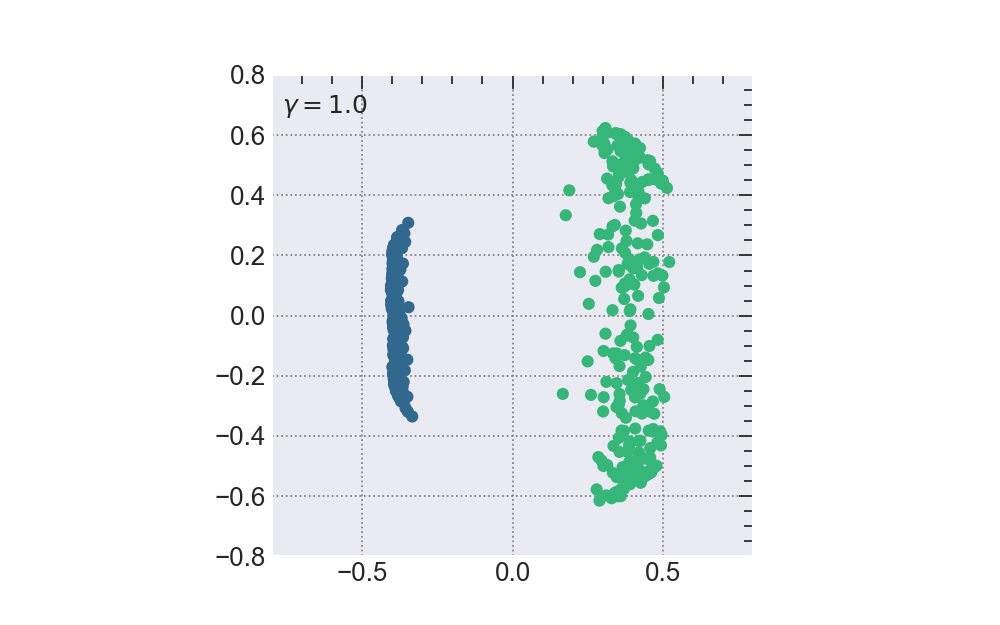

In [17]:
%matplotlib notebook

kpca_demo()

Os resultados acima são bastante sensíveis à escolha dos hiperparâmetros. Para explorar isso, vamos executar novamente `kpca_demo` com diferentes valores de $\gamma$.

<IPython.core.display.Javascript object>


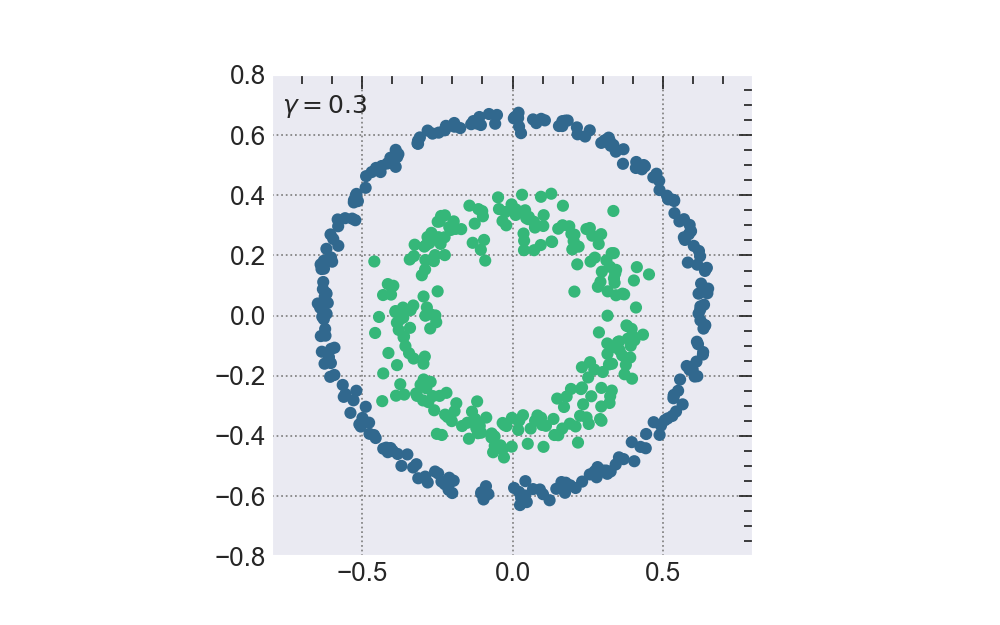

<IPython.core.display.Javascript object>


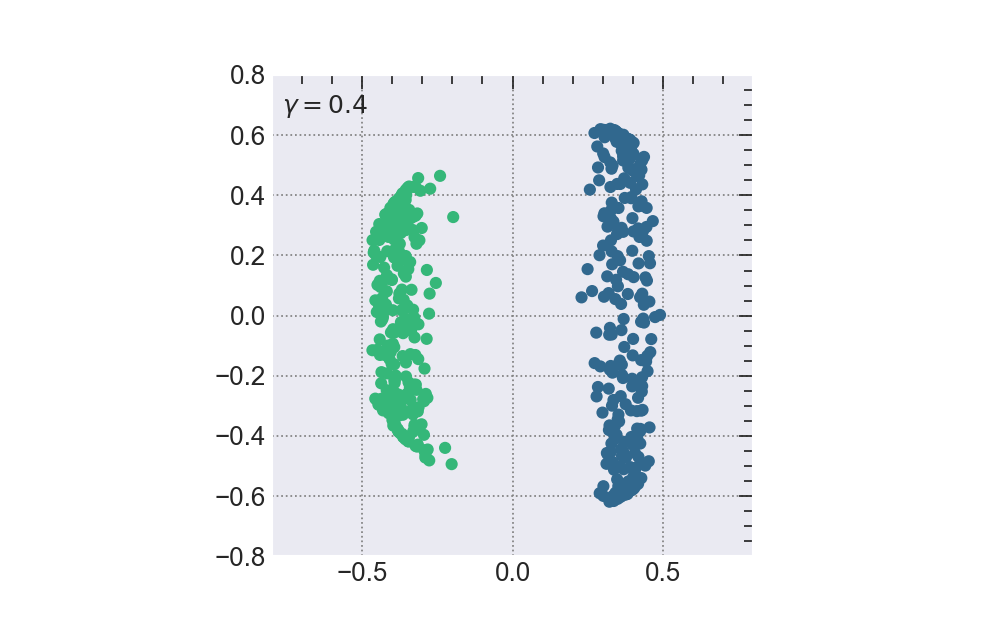

<IPython.core.display.Javascript object>


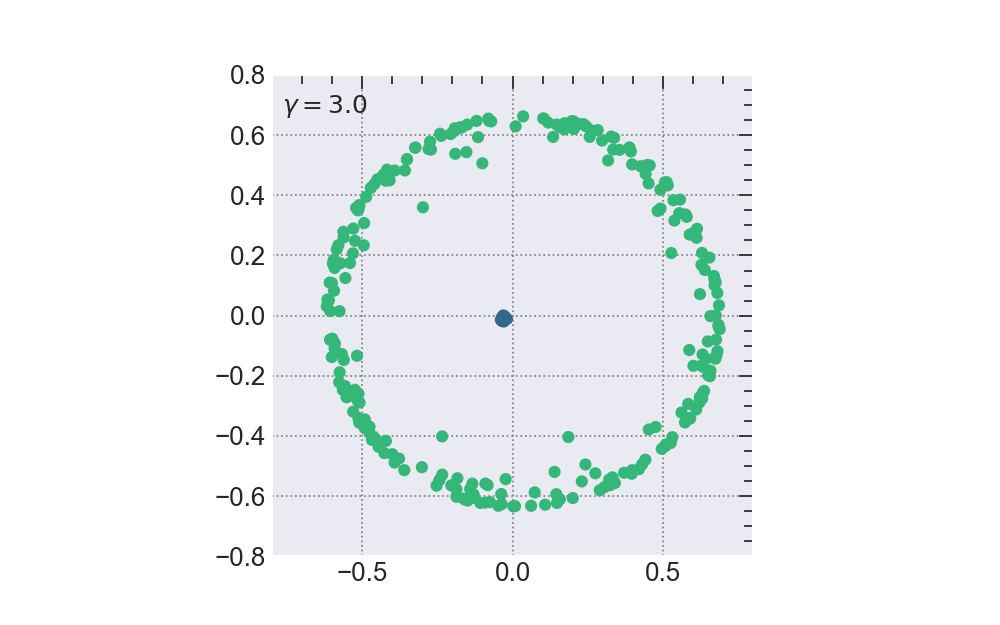

<IPython.core.display.Javascript object>


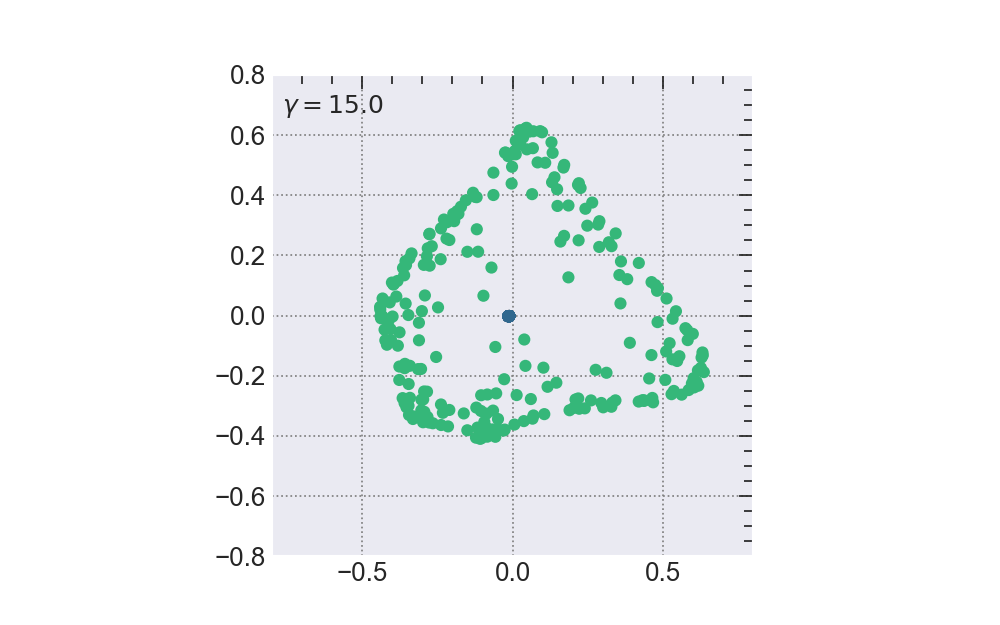

In [18]:
for gamma in (0.3, 0.4, 3., 15.):
    kpca_demo(gamma)
    plt.show()

Os resultados são bem ajustados e pequenas variações em $\gamma$ podem destruir a separação linear. A sensibilidade a $\gamma$ não é muito surpreendente, pois é um parâmetro da função kernel. No entanto, os resultados do KernelPCA também podem mudar drasticamente com uma pequena alteração nos dados de entrada. Consulte este [problema do github](https://github.com/scikit-learn/scikit-learn/issues/10530) para obter detalhes.

## 4. Incorporação linear local

O **truque do kernel** não é a única maneira de aproveitar métodos lineares para problemas não lineares. Para o nosso próximo exemplo, consideramos a **incorporação linear local** (LLE), que é um tipo de "aprendizagem múltipla", ou seja, um método de redução de dimensionalidade para dados em uma variedade não linear.

Primeiro vamos ver alguns dados 3D que são claramente 2D, mas requerem uma decomposição não linear.

<IPython.core.display.Javascript object>


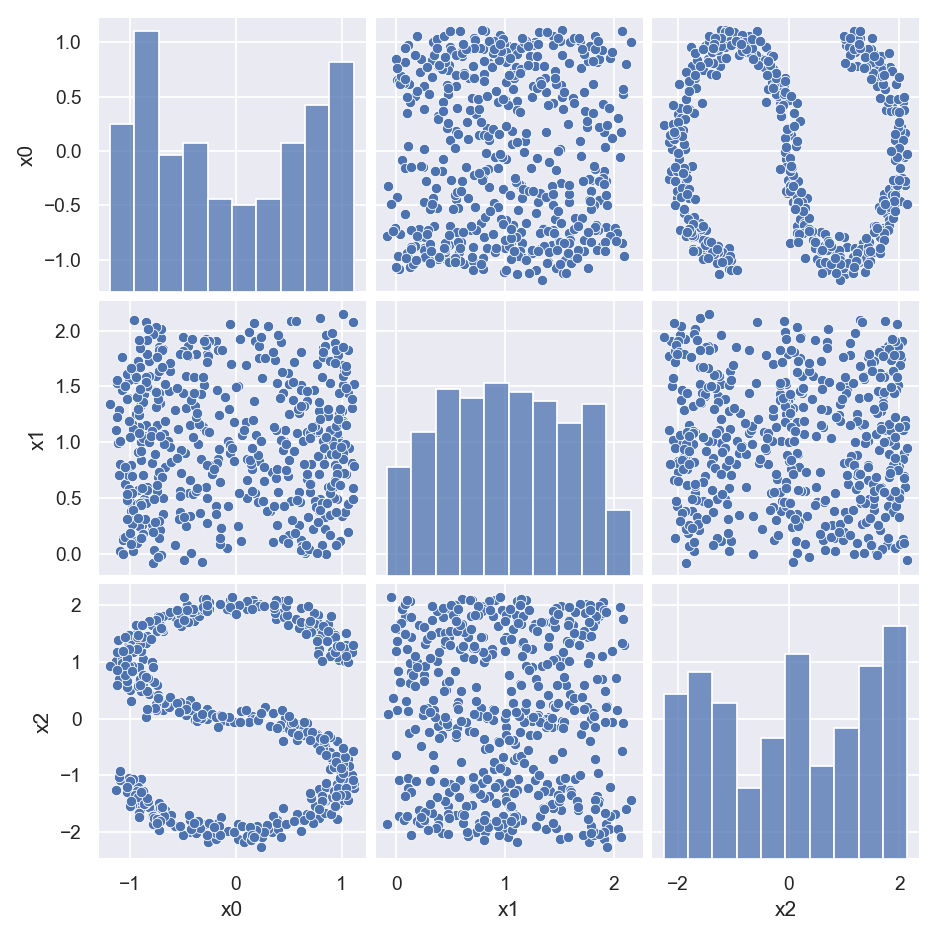

In [19]:
sns.pairplot(ess_data)

O pairplot é confuso até que você veja o seguinte gráfico onde, além disso, cada ponto é colorido de acordo com sua coordenada 1D verdadeira ao longo da direção principal do coletor (armazenado na coluna `y` de `ess_targets`):

<IPython.core.display.Javascript object>


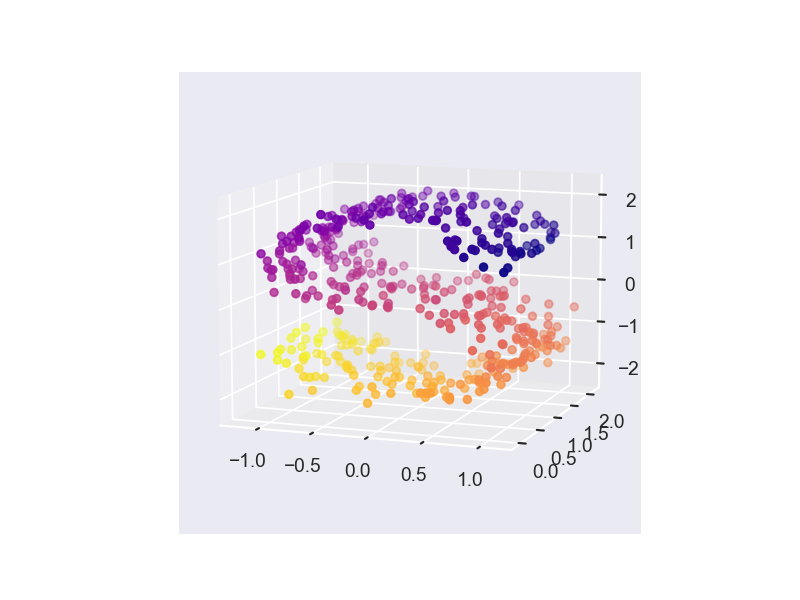

In [20]:
from mpl_toolkits.mplot3d import Axes3D

def plot_ess_3d():
    X = ess_data.values
    y = ess_targets['y']
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='plasma')
    ax.view_init(10, -70)
    
plot_ess_3d()

O LLE aproveita o fato de que a variedade é "plana" na vizinhança de cada amostra, portanto pode ser descrita localmente com uma aproximação linear. Construímos uma aproximação linear local para uma amostra $\overrightarrow{X_{i}}$ como:

$$\boxed{\overrightarrow{X_{i}}\approxeq\sum_{j\neq i}W_{ij}\overrightarrow{X_{j}}}$$

em relação aos pesos $n\times N$ em $W$.

O principal insight do LLE é que, uma vez que um conjunto adequado de pesos $W$ tenha sido encontrado:

- eles descrevem completamente a geometria local do coletor, e
- esta geometria pode então ser *transferida* para outro espaço (menor) de variáveis latentes.

A maneira como isso funciona é minimizar uma segunda função objetivo muito semelhante

$$\boxed{\sum_{i}\Bigg|\overrightarrow{Y_{i}}-\sum_{j\neq i}W_{ij}\overrightarrow{X_{j}}\Bigg|^{2}}$$

onde cada amostra $X_{i}$ tem um $Y_{i}$ correspondente, mas estes podem ter dimensões completamente diferentes! Observe que, embora as funções de metas pareçam semelhantes, os parâmetros que minimizamos são diferentes a cada vez:

- Primeiro minimizamos em relação aos elementos de $W$, com os dados de entrada $X$ fixos.

- Em seguida, minimizamos em relação às variáveis latentes $Y_{i}$, com a matriz de pesos $W$ fixa.

Este método foi descoberto em 2000 e o [artigo original](https://www.science.org/doi/10.1126/science.290.5500.2323) é bastante acessível.

O [método LLE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html) reside no módulo `sklearn` chamado `manifold` e segue o padrão de chamada usual, com dois hiperparâmetros significativos:

- O número de vizinhos mais próximos a serem usados para calcular $W$.

- O número de variáveis latentes (componentes) a serem usadas em $Y$.

Para obter resultados reproduzíveis, você também deve passar um RandomState.

In [21]:
gen = np.random.RandomState(seed=123)
fit = manifold.LocallyLinearEmbedding(n_neighbors=10, n_components=2, random_state=gen).fit(ess_data)
Y = fit.transform(ess_data)

Depois de projetar no espaço latente, descobrimos que a forma em S foi efetivamente achatada, embora não em um belo retângulo:

<IPython.core.display.Javascript object>


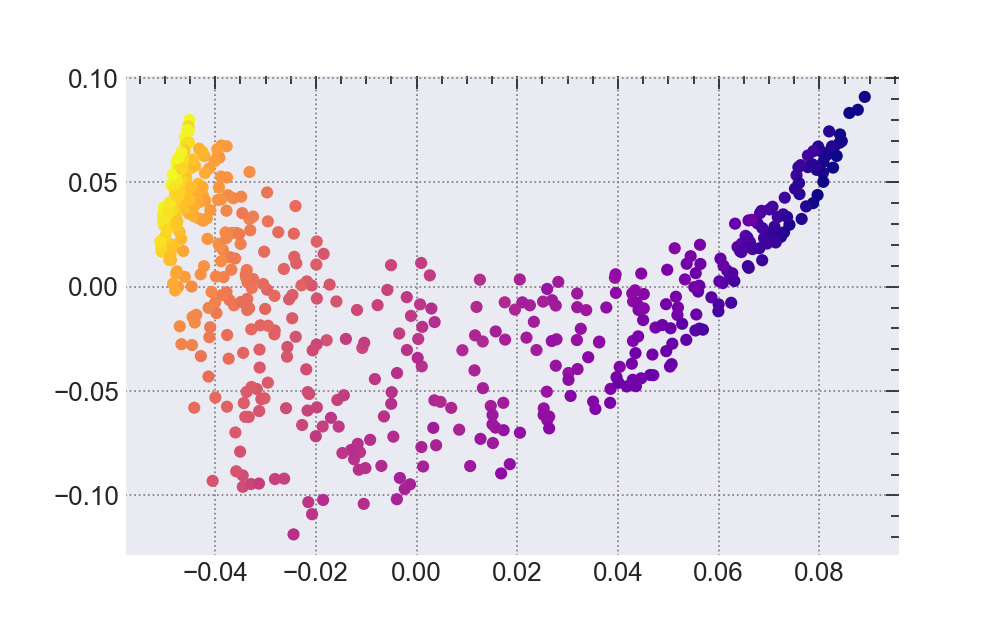

In [22]:
plt.figure(figsize = (8,5))
plt.scatter(Y[:, 0], Y[:, 1], s=None, c=ess_targets['y'], cmap='plasma')
opt_plot()

Comparamos isso com o que um PCA linear encontra:

<IPython.core.display.Javascript object>


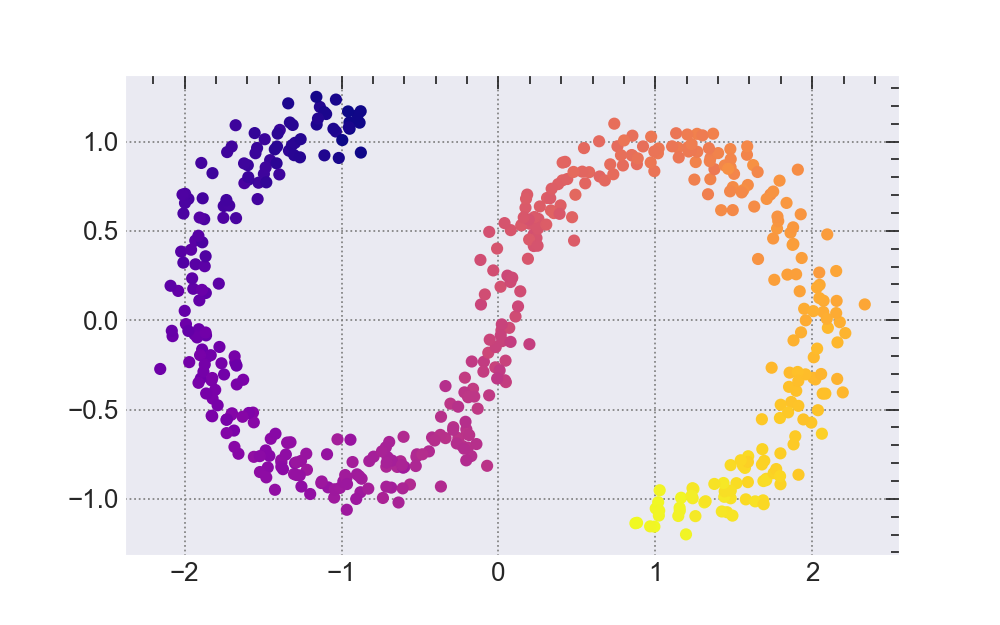

In [23]:
fit = decomposition.PCA(n_components=2, random_state=gen).fit(ess_data)
Y2 = fit.transform(ess_data)
plt.figure(figsize = (8,5))
plt.scatter(Y2[:, 0], Y2[:, 1], s=None, c=ess_targets['y'], cmap='plasma')
opt_plot()

Ou um KernelPCA:

<IPython.core.display.Javascript object>


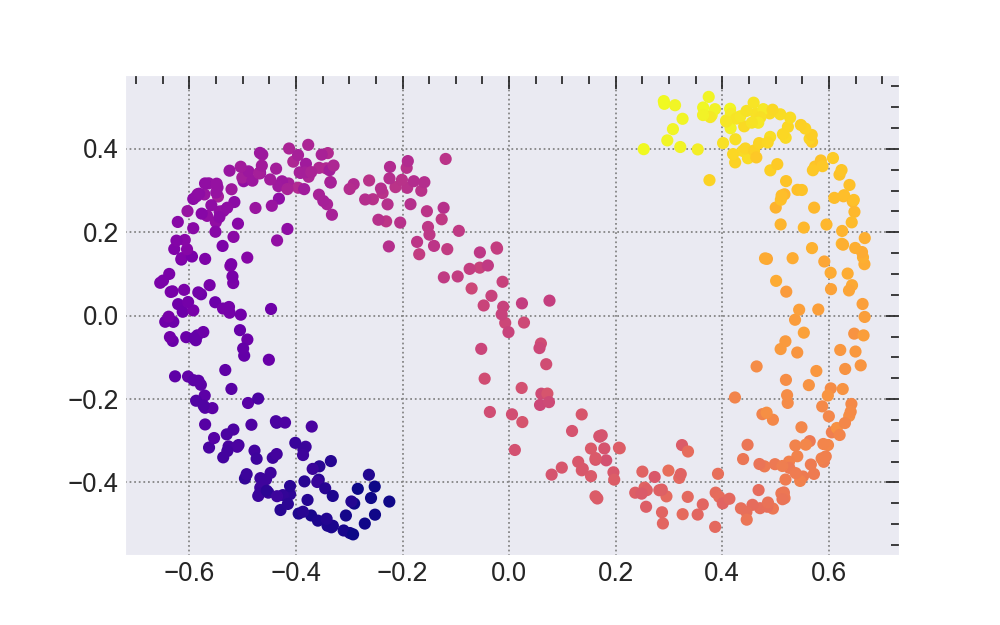

In [24]:
fit = decomposition.KernelPCA(kernel='rbf', n_components=2, random_state=gen).fit(ess_data)
Y3 = fit.transform(ess_data)
plt.figure(figsize = (8,5))
plt.scatter(Y3[:, 0], Y3[:, 1], c=ess_targets['y'], cmap='plasma')
opt_plot()

A classe `sklearn` LLE também fornece algumas variantes de LLE que podem ter um desempenho ainda melhor nesse problema, por exemplo (observe os `n_neighbors` maiores necessários - outro exemplo de ajuste fino):

<IPython.core.display.Javascript object>


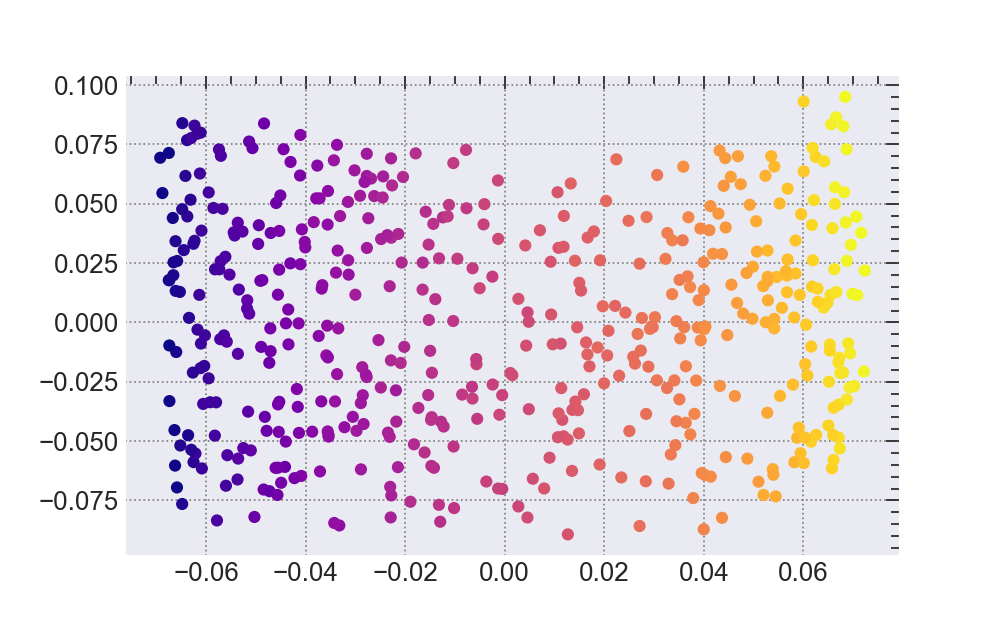

In [25]:
fit = manifold.LocallyLinearEmbedding(n_neighbors=25, n_components=2, method='ltsa', random_state=gen).fit(ess_data)
Y4 = fit.transform(ess_data)
plt.figure(figsize = (8,5))
plt.scatter(Y4[:, 0], Y4[:, 1], s=None, c=ess_targets['y'], cmap='plasma')
opt_plot()

![image](https://c.tenor.com/hEOM8E4epvgAAAAC/hahaha-thats-all-folks.gif)

---

*A longo prazo, a inteligência artificial e automação tomarão muito do que dá aos humanos um sentimento de propósito.*
- Matt Belamy, vocalista da banda **Muse**.

---

## Para se divertir!

- [Lista de problemas #05](https://github.com/GabrielWendell/Intro_ML/blob/main/Listas/Problemas5.ipynb)

---